In [1]:
## import some modules between which also our HamFit_py

import HamF_py as hamf
from iminuit import Minuit
import numpy as np
import pyhf
import matplotlib.pyplot as plt
import modifier
import json

/home/mcolonna/.conda/envs/env_2024_11_25/etc/cling/std.modulemap:257:29: warning: unknown attribute 'optional' [-Wignored-attributes]
  module "memory_resource" [optional] {
                            ^
/home/mcolonna/.conda/envs/env_2024_11_25/etc/cling/std.modulemap:447:27: warning: unknown attribute 'optional' [-Wignored-attributes]
  module "bits/chrono.h" [optional] {
                          ^
/home/mcolonna/.conda/envs/env_2024_11_25/etc/cling/std.modulemap:531:41: warning: unknown attribute 'optional' [-Wignored-attributes]
  explicit module "bits_ranges_base_h" [optional] {
                                        ^
/home/mcolonna/.conda/envs/env_2024_11_25/etc/cling/std.modulemap:538:32: warning: unknown attribute 'optional' [-Wignored-attributes]
  module "bits/ranges_util.h" [optional] {
                               ^
/home/mcolonna/.conda/envs/env_2024_11_25/etc/cling/std.modulemap:559:40: warning: unknown attribute 'optional' [-Wignored-attributes]
  module "bits/uses

Welcome to JupyROOT 6.28/04


In [2]:
# create the fitter 
# not yet optimized for the pyhf interface
# all the information necessary is stored in a fitter even if it is not (yet) trivial to retrieve

reader = hamf.Reader("./B02DstTauNu_TauMu.config")
fitter = reader.createFitter()

# store a toy as data in the fitter object
params_toy = {"SM" : 1., "Re_S_qLlL" : 0., "Im_S_qLlL" : 0., "Re_S_qRlL" : 0., "Im_S_qRlL" : 0.,  "Re_V_qLlL" : 0., "Im_V_qLlL" : 0. , "Re_V_qRlL" : 0., "Im_V_qRlL" : 0., "Re_T_qLlL" : 0.05, "Im_T_qLlL" : +0.1, "delta_RhoSq" : 0., "delta_cSt" : 0., "delta_chi21" : 0., "delta_chi2p" : 0., "delta_chi3p" : 0., "delta_eta1" : 0., "delta_etap" : 0., "delta_phi1p" : 0., "delta_beta21" : 0., "delta_beta3p" : 0.,"lumi" : 1.}
fitter._data = fitter._template_list[0].generate_toy(**params_toy) + fitter._template_list[1].generate_toy(**params_toy)

[0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


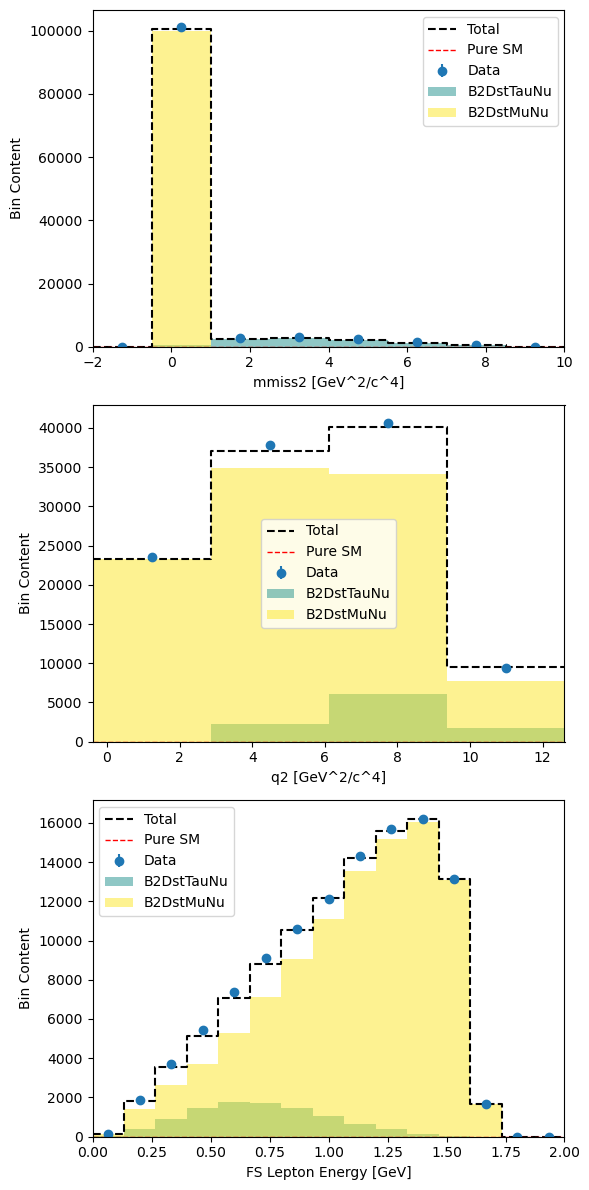

In [3]:
# plot an example (FFs are shared among the two modes)
# the WCs (except for SM) are injected only in the tau mode
params = {"SM" : 1., "Re_S_qLlL" : 0., "Im_S_qLlL" : 0., "Re_S_qRlL" : 0., "Im_S_qRlL" : 0.,  "Re_V_qLlL" : 0., "Im_V_qLlL" : 0. , "Re_V_qRlL" : 0., "Im_V_qRlL" : 0., "Re_T_qLlL" : 0.0, "Im_T_qLlL" : +0., "delta_RhoSq" : 0., "delta_cSt" : 0., "delta_chi21" : 0., "delta_chi2p" : 0., "delta_chi3p" : 0., "delta_eta1" : 0., "delta_etap" : 0., "delta_phi1p" : 0., "delta_beta21" : 0., "delta_beta3p" : 0.,"lumi" : 1.}
fitter.plot(**params)

In [4]:
# Definition of the nominal and the alternative models for the pyhf test

def SM_dist_sgnl():
    params_SM = {"SM" : 1., "Re_S_qLlL" : -0., "Im_S_qLlL" : 0. , "Re_S_qRlL" : 0., "Im_S_qRlL" : 0.,  "Re_V_qLlL" : 0., "Im_V_qLlL" : 0. , "Re_V_qRlL" : 0., "Im_V_qRlL" : 0., "Re_T_qLlL" : 0.0, "Im_T_qLlL" : +0., "delta_RhoSq" : 0.0, "delta_cSt" : 0.0, "delta_chi21" : 0., "delta_chi2p" : 0., "delta_chi3p" : 0., "delta_eta1" : 0., "delta_etap" : 0., "delta_phi1p" : 0., "delta_beta21" : 0., "delta_beta3p" : 0.,"lumi" : 1.}
    res = np.zeros(fitter._template_list[0]._nobs)
    for temp in fitter._template_list:
        res += temp.generate_template(**params_SM)
    return res
def NP_dist_sgnl(**kwargs):
    params_NP = {"SM" : kwargs["SM"], "Re_S_qLlL" : kwargs["Re_S_qLlL"], "Im_S_qLlL" : kwargs["Im_S_qLlL"], "Re_S_qRlL" : kwargs["Re_S_qRlL"], "Im_S_qRlL" : kwargs["Im_S_qRlL"],  "Re_V_qLlL" : kwargs["Re_V_qLlL"], "Im_V_qLlL" : kwargs["Im_V_qLlL"], "Re_V_qRlL" : kwargs["Re_V_qRlL"], "Im_V_qRlL" : kwargs["Im_V_qRlL"], "Re_T_qLlL" : kwargs["Re_T_qLlL"], "Im_T_qLlL" : kwargs["Im_T_qLlL"],"delta_RhoSq" : kwargs["FFs[8]"], "delta_cSt" : kwargs["FFs[0]"], "delta_chi21" : kwargs["FFs[6]"], "delta_chi2p" : kwargs["FFs[2]"], "delta_chi3p" : kwargs["FFs[9]"], "delta_eta1" : kwargs["FFs[7]"], "delta_etap" : kwargs["FFs[3]"], "delta_phi1p" : kwargs["FFs[1]"], "delta_beta21" : kwargs["FFs[5]"], "delta_beta3p" : kwargs["FFs[4]"],"lumi" : 1.}
    res = np.zeros(fitter._template_list[0]._nobs)
    for temp in fitter._template_list:
        res += temp.generate_template(**params_NP)
    return res


In [5]:
# Definition of the custom modifiers as the Wilson coefficients and the eigenvectors of the FFs

new_params = {
                'SM'   :{'inits': (1.,), 'bounds': ((0., 10.),), 'paramset_type': 'unconstrained'},
                'Re_S_qLlL'   :{'inits': (0.,), 'bounds': ((-1.,1.),), 'paramset_type': 'unconstrained'},
                'Im_S_qLlL'   :{'inits': (0.,), 'bounds': ((-2.,2.),), 'paramset_type': 'unconstrained'},
                'Re_S_qRlL'   :{'inits': (0.,), 'bounds': ((-1.,1.),), 'paramset_type': 'unconstrained'},
                'Im_S_qRlL'   :{'inits': (0.,), 'bounds': ((-2.,2.),), 'paramset_type': 'unconstrained'},
                'Re_V_qLlL'   :{'inits': (0.,), 'bounds': ((-0.3,0.3),), 'paramset_type': 'unconstrained'},
                'Im_V_qLlL'   :{'inits': (0.,), 'bounds': ((-1.,1.),), 'paramset_type': 'unconstrained'},
                'Re_V_qRlL'   :{'inits': (0.,), 'bounds': ((-0.3,0.3),), 'paramset_type': 'unconstrained'},
                'Im_V_qRlL'   :{'inits': (0.,), 'bounds': ((-1.,1.),), 'paramset_type': 'unconstrained'},
                'Re_T_qLlL'   :{'inits': (0.,), 'bounds': ((-0.1,0.1),), 'paramset_type': 'unconstrained'},
                'Im_T_qLlL'   :{'inits': (0.,), 'bounds': ((-0.2,0.2),), 'paramset_type': 'unconstrained'},
                'FFs'         :{'inits': (0.,0.,0.,0.,0.,0.,0.,0.,0.,0.), 'bounds': (),
                                'cov': [[0.04*0.04,0.,0.,0.,0.,0.,0.,0.,0.,0.],
                                        [0.,0.23*0.23,0.,0.,0.,0.,0.,0.,0.,0.],
                                        [0.,0.,0.05*0.05,0.,0.,0.,0.,0.,0.,0.],
                                        [0.,0.,0.,0.11*0.11,0.,0.,0.,0.,0.,0.],
                                        [0.,0.,0.,0.,0.01*0.01,0.,0.,0.,0.,0.],
                                        [0.,0.,0.,0.,0.,0.04*0.04,0.,0.,0.,0.],
                                        [0.,0.,0.,0.,0.,0.,0.11*0.11,0.,0.,0.],
                                        [0.,0.,0.,0.,0.,0.,0.,0.21*0.21,0.,0.],
                                        [0.,0.,0.,0.,0.,0.,0.,0.,0.10*0.10,0.],
                                        [0.,0.,0.,0.,0.,0.,0.,0.,0.,0.10*0.10],],
                                'paramset_type': 'constrained_by_normal'}
                }         


cmod_sgnl = modifier.Modifier(new_params, NP_dist_sgnl, SM_dist_sgnl)

In [6]:
# we than build a pyhf model

data_init_sgnl = SM_dist_sgnl()
#data_init_norm = SM_dist_norm()

spec = {
  "channels": [
    {
      "name": "doublechannel",
      "samples": [
        {
          "name": "signal",
          "data": data_init_sgnl.tolist(),
          "modifiers": [
            {
                "name": "mu",
                "type": "normfactor",
                "data": None
            }
          ]
        },
      ]
    } 
  ]
}


model = pyhf.Model(spec)
custom_mod = {
                "name": "custom_modifier",
                "type": "custom",
                "data":
                    {
                        "expr": "custom_weight_fn",
                    }
              }

model = modifier.add_to_model(model, ['doublechannel'], ['signal'], cmod_sgnl.expanded_pyhf, custom_mod)

In [7]:
modifier.save('B02DstTauNu_model.json', model.spec, [cmod_sgnl], fitter._data.tolist())

model, alt_yields = modifier.load('B02DstTauNu_model.json', NP_dist_sgnl, SM_dist_sgnl, return_data=True)

data = alt_yields + model.config.auxdata

In [8]:
# print the correlation infos

cmod_sgnl.corr_infos

{'FFs': {'mean': (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0),
  'uvec': array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.04, 0.  ],
         [0.23, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
         [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.05, 0.  , 0.  , 0.  ],
         [0.  , 0.  , 0.11, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
         [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01],
         [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.04, 0.  , 0.  ],
         [0.  , 0.  , 0.  , 0.11, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
         [0.  , 0.21, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
         [0.  , 0.  , 0.  , 0.  , 0.  , 0.1 , 0.  , 0.  , 0.  , 0.  ],
         [0.  , 0.  , 0.  , 0.  , 0.1 , 0.  , 0.  , 0.  , 0.  , 0.  ]])}}

In [9]:
# defining the starting values of the d.o.f.
init = model.config.suggested_init()
init[0] = 1. #SM
init[1] = 0. #ReSLL
init[2] = 0. #ImSLL
init[3] = 0. #ReSRL
init[4] = 0. #ImSRL
init[5] = 0. #ReVLL
init[6] = 0. #ImVLL
init[7] = 0. #ReVRL
init[8] = 0. #ImVRL
init[9] = 0. #ReTLL
init[10] = 0. #ImTLL

init[11] = 0. #FF1
init[12] = 0. #FF2
init[13] = 0. #FF3
init[14] = 0. #FF4
init[15] = 0. #FF5
init[16] = 0. #FF6
init[17] = 0. #FF7
init[18] = 0. #FF8
init[19] = 0. #FF9
init[20] = 0. #FF10

init[21] = 1. #mu nominal

In [10]:
# fixing the values of some of the d.o.f.
fixed = model.config.suggested_fixed()
#fixed[0] = True #SM
fixed[1] = True #ReSLL
fixed[2] = True #ImSLL
fixed[3] = True #ReSRL
fixed[4] = True #ImSRL
fixed[5] = True #ReVLL
fixed[6] = True #ImVLL
fixed[7] = True #ReVRL
fixed[8] = True #ImVRL
#fixed[9] = True #ReTLL
#fixed[10] = True #ImTLL

fixed[11] = True #FF1
fixed[12] = True #FF2
fixed[13] = True #FF3
fixed[14] = True #FF4
fixed[15] = True #FF5
fixed[16] = True #FF6
fixed[17] = True #FF7
fixed[18] = True #FF8
fixed[19] = True #FF9
fixed[20] = True #FF10
fixed[21] = True # nomi mu


In [11]:
pyhf.set_backend("numpy", pyhf.optimize.scipy_optimizer())
best_fit = pyhf.infer.mle.fit(data, model, fixed_params=fixed, init_pars=init)
pyhf.set_backend("numpy", pyhf.optimize.minuit_optimizer(verbose=True, strategy=1))
best_fit, twice_nll, OptimizeResult = pyhf.infer.mle.fit(
    data,
    model,
    init_pars=best_fit.tolist(),
    fixed_params=fixed,
    return_uncertainties=True,
    return_fitted_val=True,
    return_result_obj=True
    )

/home/mcolonna/willsoon/test/example/B02DstTauNu/modifier.py:153: RuntimeWarning: invalid value encountered in divide
  weights = np.array(alt_binned) / np.array(self.null_binned)


In [12]:
best_fit_dict = modifier.par_dict(model, best_fit)
for i in range(len(best_fit)):
    print(f"{model.main_model.modifiers_appliers['custom'].param_viewer.allpar_viewer.names[i]} = {best_fit[i][0]} +/- {best_fit[i][1]}")


SM = 1.0027448578440321 +/- 0.0015815928475134688
Re_S_qLlL = 0.0 +/- 0.0
Im_S_qLlL = 0.0 +/- 0.0
Re_S_qRlL = 0.0 +/- 0.0
Im_S_qRlL = 0.0 +/- 0.0
Re_V_qLlL = 0.0 +/- 0.0
Im_V_qLlL = 0.0 +/- 0.0
Re_V_qRlL = 0.0 +/- 0.0
Im_V_qRlL = 0.0 +/- 0.0
Re_T_qLlL = 0.04996772342055432 +/- 0.004619250526463083
Im_T_qLlL = -0.09852694010152867 +/- 0.002470254688640934
FFs_decorrelated[0] = 0.0 +/- 0.0
FFs_decorrelated[1] = 0.0 +/- 0.0
FFs_decorrelated[2] = 0.0 +/- 0.0
FFs_decorrelated[3] = 0.0 +/- 0.0
FFs_decorrelated[4] = 0.0 +/- 0.0
FFs_decorrelated[5] = 0.0 +/- 0.0
FFs_decorrelated[6] = 0.0 +/- 0.0
FFs_decorrelated[7] = 0.0 +/- 0.0
FFs_decorrelated[8] = 0.0 +/- 0.0
FFs_decorrelated[9] = 0.0 +/- 0.0
mu = 1.0 +/- 0.0


Text(0, 0.5, '(θ-θ̂)/Δθ')

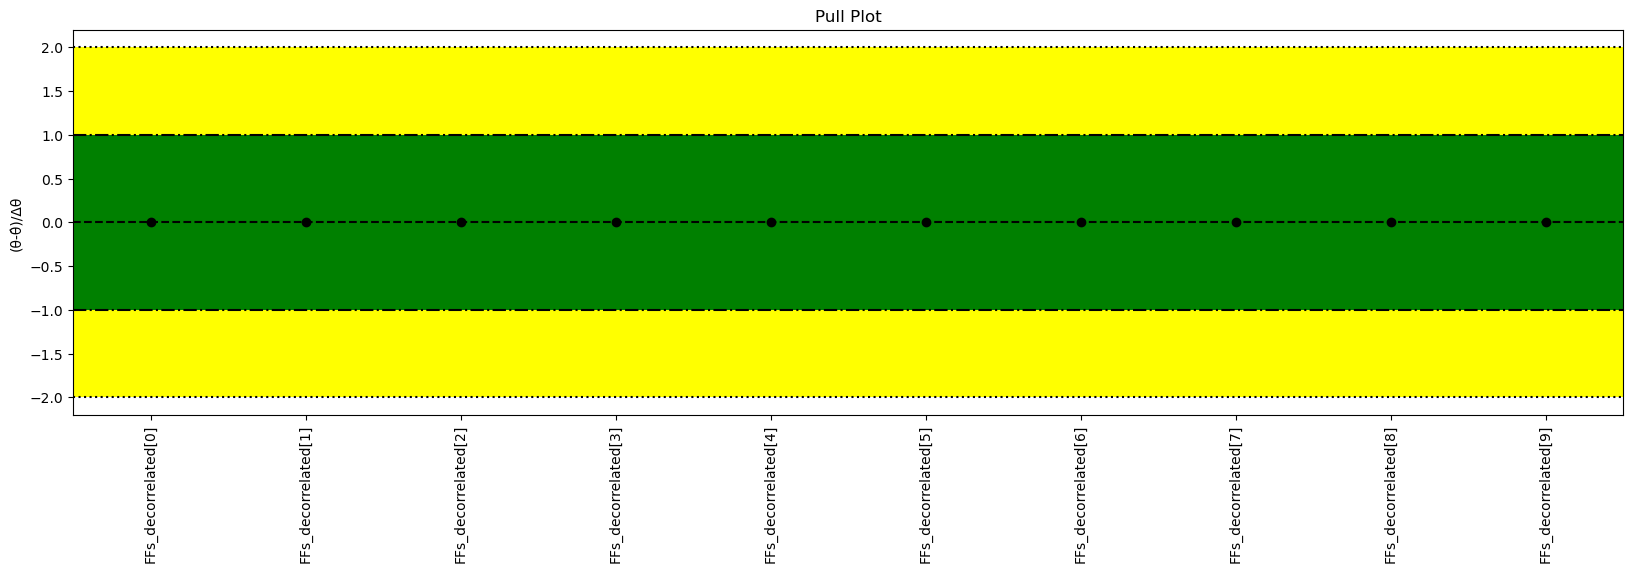

In [13]:
pulls = pyhf.tensorlib.concatenate([(best_fit[model.config.par_slice(k),0] - model.config.param_set(k).suggested_init)/model.config.param_set(k).width() for k in model.config.par_order  if model.config.param_set(k).constrained])
pullerr = pyhf.tensorlib.concatenate([best_fit[model.config.par_slice(k),1]/model.config.param_set(k).width() for k in model.config.par_order  if model.config.param_set(k).constrained])
labels = np.asarray(['{}[{}]'.format(k,i) if model.config.param_set(k).n_parameters > 1 else k  for k in model.config.par_order  if model.config.param_set(k).constrained for i in range(model.config.param_set(k).n_parameters)])

fitted = best_fit[:,0]
fiterr = best_fit[:,1]

plt.hlines([-2,2],-0.5,len(pulls)-0.5, colors= 'k',linestyles = 'dotted')
plt.hlines([-1,1],-0.5,len(pulls)-0.5, colors= 'k',linestyles = 'dashdot')
plt.fill_between([-0.5,len(pulls)-0.5],[-2,-2],[2,2],facecolor = 'yellow')
plt.fill_between([-0.5,len(pulls)-0.5],[-1,-1],[1,1],facecolor = 'green')
plt.hlines([0],-0.5,len(pulls)-0.5, colors= 'k',linestyles = 'dashed')
plt.scatter(range(len(pulls)),pulls, c = 'k')
plt.errorbar(range(len(pulls)),pulls, c = 'k',xerr = 0, yerr = pullerr, marker = '.', fmt='none')
plt.xticks(range(len(pulls)),labels,rotation = 90);
plt.gcf().set_size_inches(20,5)
plt.xlim(-0.5,len(pulls)-0.5)
plt.title('Pull Plot')
plt.ylabel('(θ-θ̂)/Δθ')


[0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


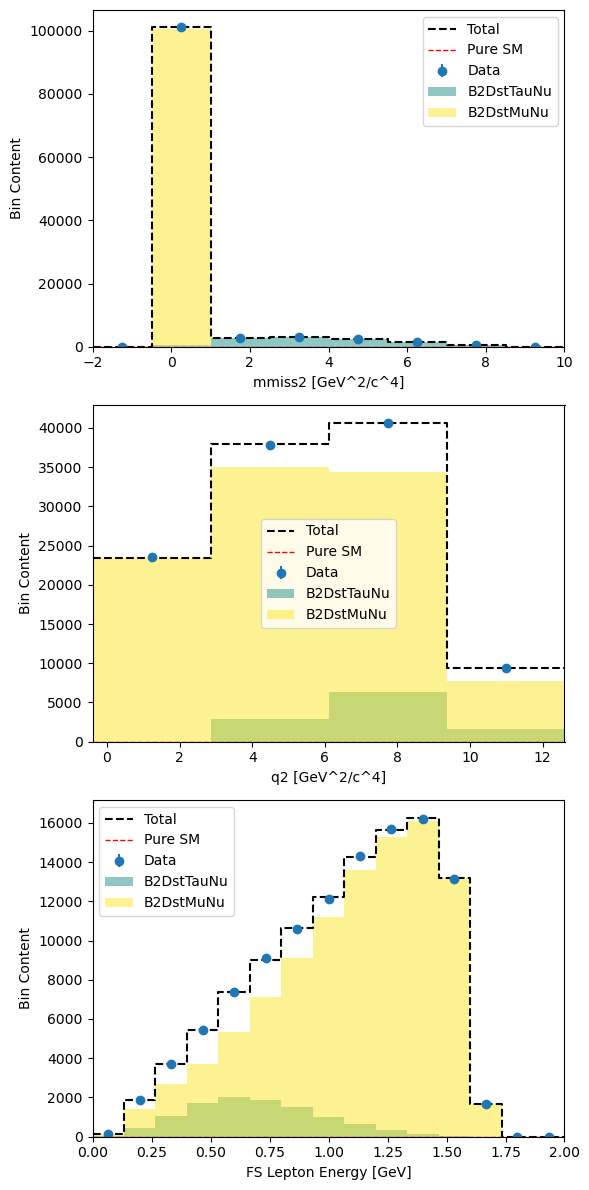

In [14]:
best_fit_rot = cmod_sgnl.rotate_pars({k:v[0] if len(np.shape(v))==1 else [p[0] for p in v] for k, v in best_fit_dict.items()})

params = dict(zip(params_toy.keys(),best_fit_rot.values()))
fitter.plot(**params)

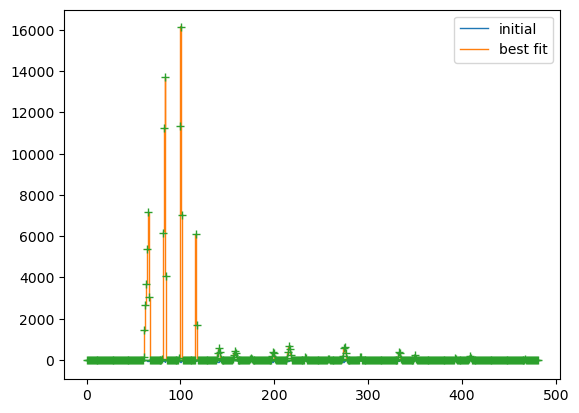

In [15]:
inits = model.config.suggested_init()
plt.stairs(model.expected_actualdata(inits)-model.expected_actualdata(best_fit[:,0]), label="initial")
plt.stairs(model.expected_actualdata(best_fit[:,0]), label = "best fit")
plt.plot(np.linspace(0.5,480.5,480), fitter._data, '+')
plt.legend()

In [16]:
# integrated with REDIST
# 2 x packages
# simplicitic examples one for iminuit 1
#
# simplistic example including the background
#
# for the paper: show that the systematic are improved by the combination
#
# compare hadronic tau and muonic tau:
# run3 hadronic vs muonic : b->c
#
# pseudoscalar decay (barionic decay)

In [17]:
best_fit[:,0]

array([ 1.00274486,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.04996772,
       -0.09852694,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  1.        ])